# **Classify reviews Unsing a Naive Bayes Classifier With data augmentation on a larger dataset**


This code classify reviews into different classes using Naive Bayes classifier and a Vectorizer

The data is augmented using : synnonyms and removal augmentations

The code will be enriched whenever we need to do more augmentation of our data



# **How to use the code**
The code was run on google colab, each file used must be put in one's peronal google drive.

As of today, google colab can only access to the drive of the person that is running the code, hence by mounting google colab on the drive, only the current user's drive is visible to colab

Therefore, for executing the code, the folder named code_hexamind should be put directly in one's drive.

Please note that the csv file that contains the data is extracted from the common google sheet:
https://docs.google.com/spreadsheets/d/1Gqz35QwGKea6qCE13bAVGv1xhs7Bn9u_8aJF5ZtLxgg/edit#gid=1375721917

As Yves requested, there must be only one file that contains the reviews. Hence I save a csv from that file and put it in the same directory. The csv is put inside the same folder with the same name: selected_df - All.csv 

When I work on my google colaboratory and my drive, I must use my link. Only Yves can use directly the link to the csv file as he is the owner of the folder. I hence, in this code, keep the two paths for the file, one for me as it is executed on my drive, and one for Yves when he wants to execute from his shared folder.

Code Insaf 02/03/2023

# **Prerequisites**

**Importing libraries**

In [1]:
# install for multi label classification
!pip install scikit-multilearn # ! is for google colab, remove it if code run on local

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 5.2 MB/s eta 0:00:00


In [2]:
!pip install transformers==4.13.0 datasets==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 39.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.1 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=79be62e23b5df5de97b12d5d2792166f4f6f61b35816813bd98c6eebfcdae56a
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [3]:
!pip install numpy requests nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 19.6 MB/s eta 0:00:00


In [4]:
#hide
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk

from datasets import Dataset, DatasetDict

In [5]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

**Mounting the drive**

In [6]:
# mounting the drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining the names**

In [27]:
# specifying the working directory
# My path:
main_Folder="/content/drive/My Drive/code_hexamind/1-baseline_classification/"
data_Folder = main_Folder+'data/'

# Yves's path, uncomment when needed. Please adjust if this is not your path !
#data_Folder="/content/drive/My Drive/01 - Hexamind2.ai/04 - Project/01 - Trustpilot/ScrapedReviews/"


# file of training
#csv_reviews=data_Folder+'selected_df - All.csv' 
# we use this new file which is exactly as the previous one but with more labelled data
# Note that we changed the name as we don't want to have confusions
csv_reviews=data_Folder+'selected_df - All-v.0.1.csv'


# **First, convert the csv to the dataframe we want to have**

Original shape: (2000, 35)
Selected shape: (2000, 35)


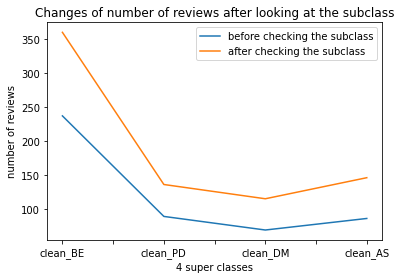

In [57]:
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def boolean_to_int(boolean):
    if boolean:
        value = 1
    else:
        value = 0
    return value



superclass_cols = ['Buying experience', 'Product', 'Delivery Mode', 'After Sales']

original_df = pd.read_csv(csv_reviews, index_col=0, header= [0,1], skipinitialspace=True)
print(f"Original shape: {original_df.shape}")

original_df.columns = original_df.columns.droplevel(0)

# Now let's make sure we select only the reviews that has some reviewers working on
#have_reviewers = ['Poon', 'Yves', 'Insaf', 'All']
#selected_df = original_df[original_df['reviewer'].isin(have_reviewers)]
selected_df = original_df
selected_df.shape
print(F"Selected shape: {selected_df.shape}")


BE_subclass = ['Buying experience', 'Digital', 'store', 'service', 'product not available']
PD_subclass = ['Product', 'fresh', 'non fresh', 'value (quality, etc.)', 'price']
DM_subclass = ['Delivery Mode', 'Drive', 'Delivery']
AS_subclass = ['After Sales', 'Carrefour', 'Other brand', 'reimbursement']

selected_df['clean_BE'] = np.any(selected_df.loc[: ,BE_subclass], axis=1)
selected_df['clean_PD'] = np.any(selected_df.loc[: ,PD_subclass], axis=1)
selected_df['clean_DM'] = np.any(selected_df.loc[: ,DM_subclass], axis=1)
selected_df['clean_AS'] = np.any(selected_df.loc[: ,AS_subclass], axis=1)

clean_superclass = ['clean_BE', 'clean_PD', 'clean_DM', 'clean_AS']

selected_df['clean_BE'] = selected_df['clean_BE'].apply(lambda x : boolean_to_int(x))
selected_df['clean_PD'] = selected_df['clean_PD'].apply(lambda x : boolean_to_int(x))
selected_df['clean_DM'] = selected_df['clean_DM'].apply(lambda x : boolean_to_int(x))
selected_df['clean_AS'] = selected_df['clean_AS'].apply(lambda x : boolean_to_int(x))

selected_df.loc[:, superclass_cols].sum().plot(label = 'before checking the subclass')
selected_df.loc[:, clean_superclass].sum().plot(label = 'after checking the subclass')
plt.legend()
plt.title('Changes of number of reviews after looking at the subclass')
plt.xlabel('4 super classes')
plt.ylabel('number of reviews')
plt.show()


In [58]:
#selected_df

# **Convert our data to fit the pipeline proposed in the book**

In [59]:
df_reviews = selected_df
#df_reviews

The second line is not useless in this new csv, so we don't remove it

In [30]:
'''df_reviews.columns = df_reviews.iloc[0]
df_reviews= df_reviews.drop(index=df_reviews.index[0])
# uncomment if you want to see
#df_reviews.head()'''

In [38]:
df_reviews.shape

(2000, 35)

In [ ]:
#df_reviews.columns

Prepare a column with multi labels

In [65]:
categories = []
df_reviews['labels']=''

for i in range (df_reviews.shape[0]):
  #print(i)
  if df_reviews['clean_BE'].iloc[i]==1:
    categories.append('Buying Experience')
  if df_reviews['clean_PD'].iloc[i]==1:
    categories.append('Product')
  if df_reviews['clean_DM'].iloc[i]==1:
    categories.append('Delivery Mode')
  if df_reviews['clean_AS'].iloc[i]==1:
    categories.append('After Sale')
  #print(categories)
  df_reviews['labels'].iloc[i]=categories
  categories = []
    

In [ ]:
#df_reviews

In [66]:
df_reviews.shape

(2000, 36)

Display the new column of labels if the review has labels

In [63]:
#df_reviews["labels"]

In [67]:
'''
for i in range (df_reviews.shape[0]):
  if df_reviews["labels"].iloc[i]!= []:
    print(df_reviews["labels"].iloc[i])
  '''  

Do some statistics

In [68]:
df_counts = df_reviews["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head().T

Number of labels: 4


,Buying Experience,After Sale,Product,Delivery Mode
labels,360,146,136,115


In [69]:
df_reviews["labels"].explode().unique() 

array(['Buying Experience', 'Delivery Mode', 'After Sale', 'Product', nan],
      dtype=object)

See how many reviews are labelled, and how many are not

Also create a new column that indicates whether the issue is unlabeled
or not

In [70]:
df_reviews["split"] = "unlabeled"
mask = df_reviews["labels"].apply(lambda x: len(x)) > 0
df_reviews.loc[mask, "split"] = "labeled"
df_reviews["split"].value_counts().to_frame()

,split
unlabeled,1500
labeled,500


In [71]:
df_reviews.columns

Index(['titles', 'ratings', 'reviewer', 'reviews', 'english', 'dates',
       'replies', 'reply_dates', 'clean_review', 'combined_reviews',
       'reviews_len', 'Buying experience', 'Digital', 'store', 'service',
       'product not available', 'Product', 'fresh', 'non fresh',
       'value (quality, etc.)', 'price', 'Delivery Mode', 'Drive', 'Delivery',
       'After Sales', 'Carrefour', 'Other brand', 'reimbursement', 'clean_BE',
       'clean_PD', 'clean_DM', 'clean_AS', 'summary', 'top_3', 'proper_n',
       'labels', 'split'],
      dtype='object', name='index')

See a sample of the reviews. note that we truncate in case the review is larger than 500 

In [73]:
for column in ["titles", "reviews", "labels"]:
    print(f"{column}: {df_reviews[column].iloc[26][:500]}\n")

titles: Carrefour pontault combaut ou ormesson…

reviews: Carrefour pontault combaut ou ormesson même combat. 
Magasins à la dérive, n affichent pas les prix, ne prennent pas en compte les bons de réduction.
Se faire rembourser, oui mais il faut batailler. Je ne parle des produits manquants et les prix des produits. J etais cliente je pense que je ne vais plus l être.
Suite à la réponse de carrefour : trop de prix manquants pour vous faire la liste par exemple les pellets à carrefour pontault , ormessons les draps etc Et ce n est qu un exemple. Bons de

labels: ['Buying Experience', 'Product']



Concatenate the title with the review's description in the body field

In [74]:
df_reviews["text"] = (df_reviews
                     .apply(lambda x: str(x["titles"]) + "\n\n" + str(x["reviews"]), axis=1))

In [75]:
len_before = len(df_reviews)
df_reviews = df_reviews.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_reviews))/len_before:.2%} duplicates.")

Removed 0.00% duplicates.


See number of reviews that has X number of words

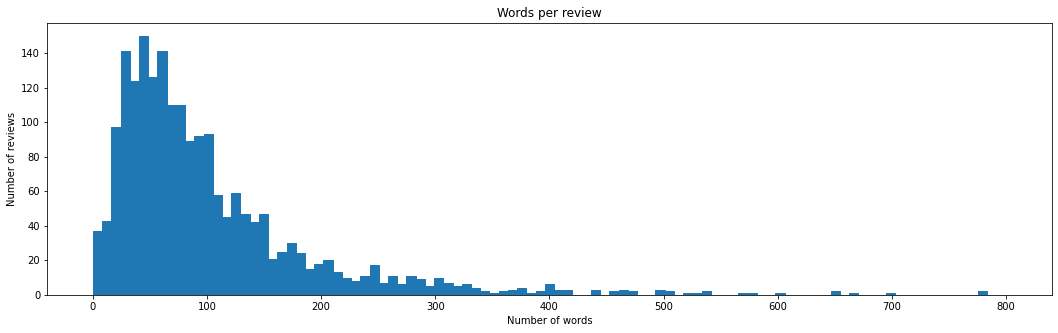

In [76]:
plt.figure(figsize=(18, 5))
(df_reviews["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 800, 100), grid=False, edgecolor="C0"))
plt.title("Words per review")
plt.xlabel("Number of words")
plt.ylabel("Number of reviews")
plt.show()

Filtering the labels

This is useful in the case where several labels can be grouped into the same category

Right now we don't need this, so we will just replicate the same labels as the 4 we have

In [77]:
label_map = {"Buying Experience": "Buying Experience",
             "Product": "Product",
             "Delivery Mode": "Delivery Mode",
             "After Sale": "After Sale"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_reviews["labels"] = df_reviews["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [78]:
all_labels

['Buying Experience', 'Product', 'Delivery Mode', 'After Sale']

Now let's look at the distribution of the new labels


In [79]:
df_counts = df_reviews["labels"].explode().value_counts()
df_counts.to_frame().T

,Buying Experience,After Sale,Product,Delivery Mode
labels,360,146,136,115


# **Augment only data with poor labels**

As noticed earlier, number of samples that have label Buying experience is the largest with 198 samples.

Let us check number of labelled samples that are different than Buying Experience.

In [81]:
df_counts = df_reviews[df_reviews["clean_BE"]==0]["labels"].explode().value_counts()
df_counts.to_frame().T

,After Sale,Product,Delivery Mode
labels,71,68,55


We need now to target those samples for the augmentation but first we need to split our dataset into labelled and unlabelled

# **Create training set**

First convert our labels into multi labels

This is actually silly, because we already have this !

But well, let's do it so that we are not lost in the book's pipeline

In [82]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
# See some examples of this transformation
# uncomment if you want to see
'''
mlb.transform([["Buying Experience"], ["Product"],["Delivery Mode"], ["After Sale"],
               ["Buying Experience", "Product"], 
               ["Delivery Mode", "After Sale"], 
               ["After Sale", "Product"],
               ["Buying Experience", "NaN"]
               ])
'''

'\nmlb.transform([["Buying Experience"], ["Product"],["Delivery Mode"], ["After Sale"],\n               ["Buying Experience", "Product"], \n               ["Delivery Mode", "After Sale"], \n               ["After Sale", "Product"],\n               ["Buying Experience", "NaN"]\n               ])\n'

Create the train/test splits iteratively to achieve balanced
labels.

In [83]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, 
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

Split the data into supervised and unsupervised datasets

In [95]:
from sklearn.model_selection import train_test_split

df_clean = df_reviews[["text", "labels", "split", "clean_BE"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

df_sup_foraugmentation = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels", "clean_BE"]]

Not the we will only augment the texts that do not belong to the Buying experience class

In [96]:
df_sup_for_augmentation = df_sup_foraugmentation[df_sup_foraugmentation["clean_BE"]==0]
df_sup_not_augmentation = df_sup_foraugmentation[df_sup_foraugmentation["clean_BE"]!=0]
print("Number of samples that will be augmented is : ", df_sup_for_augmentation.shape[0])
print("Number of samples that will NOT be augmented is : ", df_sup_not_augmentation.shape[0])

Number of samples that will be augmented is :  140
Number of samples that will NOT be augmented is :  360


Once we divided into labelled and unlabelled, let us augment the data before the splitting

We will use 2 augmentations: french synonyms and swipping text

Uncomment the other augmentations if you want to give them a try

In [97]:
set_seed(3)

aug1 = naw.SynonymAug(aug_src='wordnet',lang='fra')
aug2 = naw.RandomWordAug(action="swap")

'''
aug3 = naw.RandomWordAug()
aug4 = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="insert", aug_max=1)
augs["bt_fr_en"] = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-fr-en', 
    to_model_name='Helsinki-NLP/opus-mt-en-fr')
'''

'\naug3 = naw.RandomWordAug()\naug4 = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", \n                                device="cpu", action="insert", aug_max=1)\naugs["bt_fr_en"] = naw.BackTranslationAug(\n    from_model_name=\'Helsinki-NLP/opus-mt-fr-en\', \n    to_model_name=\'Helsinki-NLP/opus-mt-en-fr\')\n'

In order to take advantage of the accelerated codes of NLP with transformers, let us first transform our data to a dataset

In [98]:
ds_augment = DatasetDict({
    "train": Dataset.from_pandas(df_sup_for_augmentation.reset_index(drop=True))})
print('The dataset that we will augment has the followin structure :')
ds_augment

The dataset that we will augment has the followin structure :


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'clean_BE'],
        num_rows: 140
    })
})

Now, let us define a function for the data augmentation

In [99]:
def augment_text(batch):
    text_aug, labels, clean_BE = [], [], []
    i=0
    for text, label, BE  in zip(batch["text"], batch["labels"], batch["clean_BE"]):
        text_aug += [text]
        clean_BE += [BE]
        labels += [label]                    
        text_aug += [aug1.augment(text)]
        clean_BE += [BE]
        labels += [label]
        text_aug += [aug2.augment(text)]
        clean_BE += [BE]
        labels += [label]
    return [text_aug, labels, clean_BE]

And finally augment our data

In [100]:
ds_train_sample = ds_augment["train"]
[augmented_texts,augmented_labels,augmented_clean_BE]=augment_text(ds_train_sample)
df_to_add = pd.DataFrame({'text' : augmented_texts,'labels' : augmented_labels , 'clean_BE' : augmented_clean_BE}, 
                                columns=['text','labels', 'clean_BE'])
df_result=pd.concat([df_to_add, df_sup_not_augmentation])
df_sup_test=df_result[["text", "labels"]]
df_sup_test= df_sup_test.reset_index(drop=True)

# uncomment if you want to see
#df_sup_test

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Now that we are happy with the data augmentation, let us bring the data frame back to our variable `df_sup` for further processing, and clean our environment by deleting all unecessary variables

In [101]:
df_sup = df_sup_test
for i in range (df_sup.shape[0]):
  df_sup["text"].iloc[i]= str(df_sup["text"].iloc[i])

del df_sup_foraugmentation, aug1, aug2, ds_augment, ds_train_sample, augmented_texts,augmented_labels,augmented_clean_BE, df_to_add, df_sup_test

And make sure we didn't loose our data frame

In [102]:
df_sup

,text,labels
0,achat d'une sonnette sans fil de marque Rhino…...,[Product]
1,['achat baby sitter \' une sonnette sans fil d...,[Product]
2,['achat d \' une sonnette sans fil de marque R...,[Product]
3,Une semaine déjà que j'ai contacté le…\n\nUne ...,"[Product, After Sale]"
4,"[""Une semaine déjà que j ' ai contacté le … Un...","[Product, After Sale]"
...,...,...
775,Aucun contact possible avec le SAV\n\nÀ l'heur...,"[Buying Experience, Delivery Mode, After Sale]"
776,"Publicité mensongère, site online inacceptable...","[Buying Experience, Product, Delivery Mode, Af..."
777,Produit défectueux et SAV lamentable\n\nJ'ai r...,"[Buying Experience, Product, After Sale]"
778,"inacceptable, mauvais service après-vente\n\nJ...","[Buying Experience, After Sale]"


Now the data has been augmented, let us follow the pipeline and check the effect of the augmentation

# **Training an augmented dataset**

First some statistics on the resulting dataset


In [103]:
df_reviews_augment= pd.concat((df_unsup, df_sup))
df_counts_augment = df_reviews_augment["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts_augment)}")
# Display the top-8 label categories
df_counts_augment.to_frame().head().T

Number of labels: 4


,Buying Experience,After Sale,Product,Delivery Mode
labels,360,288,272,225


In [104]:
del df_reviews_augment, df_counts_augment

### **Create Training Slices**

Finally, let's create balanced training, and test sets for the supervised part

In [105]:
np.random.seed(0)
df_train, df_test = balanced_split(df_sup, test_size=0.3)

create slices of the training data with even fewer samples. We can then plot
the number of samples against the performance and investigate various regimes. We’ll
start with only eight samples per label and build up until the slice covers the full
training set

In [106]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [107]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 562
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 218
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 1500
    })
})

Create a DatasetDict with all the splits so that we can easily tokenize the
dataset and integrate with the Trainer

In [108]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))
        
# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [109]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

In [110]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 562]
Actual split sizes:
[7, 14, 28, 56, 120, 562]


## **Implement a Naive Bayesline**

Use the multilabel binarizer we already created in order
to create a new label_ids column in our training sets.

In [111]:
# ds is our dataset 
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

To measure the performance of our classifiers, we’ll use the micro and macro
F1-scores

Since we’ll be evaluating each model across
different-sized training splits, let’s create a defaultdict with a list to store the scores
per split

In [112]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

Train the model and evaluate our classifier across increasing training set sizes

In [113]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

Plot the results of this experiment

In [114]:
import matplotlib.pyplot as plt 

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

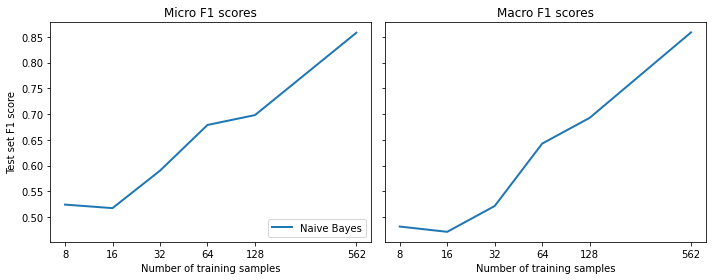

In [115]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

The different scores according to the increasing size of the split of training

In [116]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.5244072524407253,
              0.5175438596491228,
              0.5902668759811618,
              0.6790123456790124,
              0.6981450252951095,
              0.8580060422960726]})

In [117]:
macro_scores

defaultdict(list,
            {'Naive Bayes': [0.4817866153120797,
              0.47153824269011213,
              0.5216958772025638,
              0.6428657991488504,
              0.6928545594786003,
              0.8587731394160217]})

In [118]:
clf_report

{'After Sale': {'precision': 0.7916666666666666,
  'recall': 0.8837209302325582,
  'f1-score': 0.8351648351648352,
  'support': 86},
 'Buying Experience': {'precision': 0.9555555555555556,
  'recall': 0.7962962962962963,
  'f1-score': 0.8686868686868687,
  'support': 108},
 'Delivery Mode': {'precision': 0.8923076923076924,
  'recall': 0.8529411764705882,
  'f1-score': 0.8721804511278195,
  'support': 68},
 'Product': {'precision': 0.9552238805970149,
  'recall': 0.7804878048780488,
  'f1-score': 0.8590604026845637,
  'support': 82},
 'micro avg': {'precision': 0.8930817610062893,
  'recall': 0.8255813953488372,
  'f1-score': 0.8580060422960726,
  'support': 344},
 'macro avg': {'precision': 0.8986884487817324,
  'recall': 0.8283615519693728,
  'f1-score': 0.8587731394160217,
  'support': 344},
 'weighted avg': {'precision': 0.9020017866837549,
  'recall': 0.8255813953488372,
  'f1-score': 0.858702271334836,
  'support': 344},
 'samples avg': {'precision': 0.8860856269113151,
  'recall